In [44]:
%matplotlib notebook
import cvxpy as cp
import dccp
import torch
import numpy as np
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.metrics import zero_one_loss, confusion_matrix
from scipy.io import arff
import pandas as pd
import time
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_classification
import matplotlib.patches as mpatches

torch.set_default_dtype(torch.float64)
XDIM = 3
COST = 0.5
SLOPE_C = 0.5
X_LOWER_BOUND = -10
X_UPPER_BOUND = 10

# Datasets

In [45]:
def gen_data_case1():
    posX = torch.arange(-0.5, 2, 0.02)
    posX = torch.transpose(torch.stack((posX, torch.zeros(len(posX)))), 0, 1)
    negX = torch.arange(0.5, 3, 0.02)
    negX = torch.transpose(torch.stack((torch.zeros(len(negX)), negX)), 0, 1)

    X = torch.cat((posX, negX), 0)
    Y = torch.unsqueeze(torch.cat((torch.ones(len(posX)), -torch.ones(len(negX))), 0), 1)

    X, Y = shuffle(X, Y)
    return X, Y

def load_spam_dataset():
    path = r"C:\Users\sagil\Desktop\nir project\tip_spam_data\IS_journal_tip_spam.arff"
    data, meta = arff.loadarff(path)
    df = pd.DataFrame(data)
    most_disc = ['qTips_plc', 'rating_plc', 'qEmail_tip', 'qContacts_tip', 'qURL_tip', 'qPhone_tip', 'qNumeriChar_tip', 'sentistrength_tip', 'combined_tip', 'qWords_tip', 'followers_followees_gph', 'qunigram_avg_tip', 'qTips_usr', 'indeg_gph', 'qCapitalChar_tip', 'class1']
    df = df[most_disc]
    df["class1"].replace({b'spam': -1, b'notspam': 1}, inplace=True)
    df = df.sample(frac=1).reset_index(drop=True)

    Y = df['class1'].values
    X = df.drop('class1', axis = 1).values
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)
    return torch.from_numpy(X), torch.from_numpy(Y)

# Utils

In [46]:
def gen_data(N, informative_frac=1, shift_range=1, scale_range=1, noise_frac=0.01, seed=None):
    
    np.random.seed(seed)
    n_informative = informative_frac*XDIM
    n_redundant = XDIM - n_informative
    shift_arr = shift_range*np.random.randn(XDIM)
    scale_arr = scale_range*np.random.randn(XDIM)
    X, Y = make_classification(n_samples=N, n_features=XDIM, n_informative=n_informative, n_redundant=n_redundant,
                               flip_y=noise_frac, shift=shift_arr, scale=scale_arr, random_state=seed)
    Y[Y == 0] = -1
    return torch.from_numpy(X), torch.from_numpy(Y)
    
def split_data(X, Y, percentage):
    num_val = int(len(X)*percentage)
    return X[num_val:], Y[num_val:], X[:num_val], Y[:num_val]

def shuffle(X, Y):
    data = torch.cat((X, Y), 1)
    data = data[torch.randperm(data.size()[0])]
    X = data[:, :2]
    Y = data[:, 2]
    return X, Y

def conf_mat(Y1, Y2):
    num_of_samples = len(Y1)
    mat = confusion_matrix(Y1, Y2, labels=[-1, 1])*100/num_of_samples
    acc = np.trace(mat)
    return mat, acc

def pred(X, w, b):
    return torch.sign(score(X, w, b))

def calc_accuracy(Y, Ypred):
    num = len(Y)
    temp = Y - Ypred
    acc = len(temp[temp == 0])*1./num
    return acc

def evaluate_model(X, Y, w, b, ccp, strategic):
    if not strategic:
        Xopt = X
    else:
        Xopt = ccp.optimize_X(X, w, b)
    Ypred = pred(Xopt, w, b)
    return calc_accuracy(Y, Ypred)

# Visualization

In [47]:
def visualize_weights(w1, b1, w2, b2):
    fig = plt.figure()
    plt.bar(np.arange(XDIM + 1), np.append(w1, b1), color='b', alpha=0.5)
    plt.bar(np.arange(XDIM + 1), np.append(w2, b2), color='r', alpha=0.5)
    plt.show()
    
def visualize_data3D(X, Y):
    if not XDIM == 3:
        return
    
    Xpos = X[Y == 1][:100]
    Xneg = X[Y == -1][:100]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Xpos[:, 0], Xpos[:, 1], Xpos[:, 2], marker='+', color='green')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], Xneg[:, 2], marker='_', color='purple')
    plt.show()
    
def visualize_data2D(X, Y):
    if not XDIM == 2:
        return
    
    Xpos = X[Y == 1]
    Xneg = X[Y == -1]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='green')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='purple')
    plt.show()
    
def visualize_data(X, Y):
    if XDIM == 2:
        visualize_data2D(X, Y)
    else:
        visualize_data3D(X, Y)
    
def visualize_strategic_data3D(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic):
    if not XDIM == 3:
        return

    Xpos = Xval[Yval == 1][:50]
    Xneg = Xval[Yval == -1][:50]
    XposOpt = Xval_opt[Yval == 1][:50]
    XnegOpt = Xval_opt[Yval == -1][:50]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(Xpos[:, 0], Xpos[:, 1], Xpos[:, 2], marker='+', color='blue')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], Xneg[:, 2], marker='_', color='blue')

    ax.scatter(XposOpt[:, 0], XposOpt[:, 1], XposOpt[:, 2], marker='+', color='red')
    ax.scatter(XnegOpt[:, 0], XnegOpt[:, 1], XnegOpt[:, 2], marker='_', color='red')

    range_arr = torch.arange(-2, 2 + 1)
    xx, yy = torch.meshgrid(range_arr, range_arr)
    z = (-w_non_strategic[0] * xx - w_non_strategic[1] * yy - b_non_strategic) * 1. /w_non_strategic[2]
    ax.plot_surface(xx.numpy(), yy.numpy(), z.numpy(), alpha=0.2, color='blue')

    xx, yy = torch.meshgrid(range_arr, range_arr)
    z = (-w_strategic[0] * xx - w_strategic[1] * yy - b_strategic) * 1. /w_strategic[2]
    ax.plot_surface(xx.numpy(), yy.numpy(), z.numpy(), alpha=0.2, color='red')
#     ax.set_xlim3d(-1.2, 1.2)
#     ax.set_ylim3d(-1.2, 1.2)
#     ax.set_zlim3d(-1.2, 1.2)
#     ax.view_init(25, 45)
#     plt.savefig('plots/simple_strategic_classification.pdf', format='pdf')
#     plt.savefig('plots/simple_strategic_classification.eps', format='eps')
#     plt.savefig('plots/simple_strategic_classification.png', format='png')
    plt.show()

def visualize_strategic_data2D(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic):
    if not XDIM == 2:
        return

    Xpos = Xval[Yval == 1][:50]
    Xneg = Xval[Yval == -1][:50]
    XposOpt = Xval_opt[Yval == 1][:50]
    XnegOpt = Xval_opt[Yval == -1][:50]

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='blue')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='blue')

    ax.scatter(XposOpt[:, 0], XposOpt[:, 1], marker='+', color='red')
    ax.scatter(XnegOpt[:, 0], XnegOpt[:, 1], marker='_', color='red')

    range_arr = torch.arange(-0.5, 2 + 1)
    xx = torch.meshgrid(range_arr)[0]
    z = (-w_non_strategic[0] * xx - b_non_strategic) * 1. /w_non_strategic[1]
    ax.plot(xx.numpy(), z.numpy(), alpha=0.2, color='blue')

    xx = torch.meshgrid(range_arr)[0]
    z = (-w_strategic[0] * xx - b_strategic) * 1. /w_strategic[1]
    ax.plot(xx.numpy(), z.numpy(), alpha=0.2, color='red')

    plt.show()
    
def visualize_strategic_data(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic):
    if XDIM == 2:
        visualize_strategic_data2D(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic)
    else:
        visualize_strategic_data3D(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic)
        
def visualize_training_errors(train_errors, val_errors):
    fig = plt.figure()
    train_patch, = plt.plot(torch.arange(len(train_errors)), np.mean(train_errors, axis=1), color='blue', label="train")
    val_patch, = plt.plot(torch.arange(len(val_errors)), val_errors, color='orange', label="validation")
    plt.legend(handles=[train_patch, val_patch])

    plt.show()
    
def visualize_training_losses(train_losses, val_losses):
    fig = plt.figure()
    train_patch, = plt.plot(torch.arange(len(train_losses)), np.mean(train_losses, axis=1), color='blue', label="train")
    val_patch, = plt.plot(torch.arange(len(val_losses)), val_losses, color='orange', label="validation")
    plt.legend(handles=[train_patch, val_patch])
    
    plt.show()

# CCP classes

In [48]:
class CCP:
    def __init__(self, funcs):
        self.f_derivative = funcs["f_derivative"]
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(XDIM)
        self.xt = cp.Parameter(XDIM)
        self.r = cp.Parameter(XDIM)
        self.w = cp.Parameter(XDIM)
        self.b = cp.Parameter(1)

        target = self.x@self.f_derivative(self.xt, self.w, self.b) - self.g(self.x, self.w, self.b) - self.c(self.x, self.r)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        self.prob = cp.Problem(cp.Maximize(target), constraints)
        
        print("problem is DCP:", self.prob.is_dcp())
        print("problem is DPP:", self.prob.is_dpp())
        
    def ccp(self, r, w, b):
        """
        numpy to numpy
        """
        self.w.value = w
        self.b.value = b
        self.xt.value = r
        self.r.value = r
        
        result = self.prob.solve()
        diff = np.linalg.norm(self.xt.value - self.x.value)
        while diff > 0.0001:
            self.xt.value = self.x.value
            result = self.prob.solve()
            diff = np.linalg.norm(self.x.value - self.xt.value)
        return self.x.value
    
    def optimize_X(self, X, w, b):
        """
        tensor to tensor
        """
        w = w.detach().numpy()
        b = b.detach().numpy()
        X = X.numpy()
        return torch.stack([torch.from_numpy(self.ccp(x, w, b)) for x in X])

In [49]:
# somehow slower than my ccp method
class DCCP():
    
    def __init__(self, funcs):
        self.f = funcs["f"]
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.z = cp.Variable(XDIM)
        self.z.value = np.zeros(XDIM)
        y = cp.Variable(1)
        self.x = cp.Parameter(XDIM)
        self.w = cp.Parameter(XDIM)
        self.b = cp.Parameter(1)

        target =  self.f(self.z, self.w, self.b) - y
        constraints = [y == self.g(self.z, self.w, self.b) + self.c(self.z, self.x),
                       self.z >= X_LOWER_BOUND,
                       self.z <= X_UPPER_BOUND]
        self.prob = cp.Problem(cp.Maximize(target), constraints)

        print("problem is DCP:", self.prob.is_dcp())   # false
        print("problem is DCCP:", dccp.is_dccp(self.prob))  # true
        
    def optimize_X(self, X, w, b):
        """
        numpy to numpy
        """
        w = w.detach().numpy()
        b = b.detach().numpy()
        X = X.numpy()

        self.w.value = w
        self.b.value = b
        Xp = np.zeros_like(X)
        for i, sample in enumerate(X):
            self.x.value = sample
            result = self.prob.solve(method = 'dccp')
            Xp[i] = self.z.value
        return torch.from_numpy(Xp)


# Gain & Cost functions

In [50]:
def score(x, w, b):
    return x@w + b

def f(x, w, b):
    return 0.5*cp.norm(cp.hstack([1, (SLOPE_C*score(x, w, b) + 1)]), 2)

def g(x, w, b):
    return 0.5*cp.norm(cp.hstack([1, (SLOPE_C*score(x, w, b) - 1)]), 2)

def c(x, r):
    return COST*cp.sum_squares(x-r)

def f_derivative(x, w, b):
    return 0.5*SLOPE_C*((SLOPE_C*score(x, w, b) + 1)/cp.sqrt((SLOPE_C*score(x, w, b) + 1)**2 + 1))*w

def g_derivative(x, w, b):
    return 0.5*SLOPE_C*((SLOPE_C*score(x, w, b) - 1)/cp.sqrt((SLOPE_C*score(x, w, b) - 1)**2 + 1))*w

funcs = {"f": f, "g": g, "f_derivative": f_derivative, "g_derivative": g_derivative, "c": c, "score": score}

# Data generation

<IPython.core.display.Javascript object>


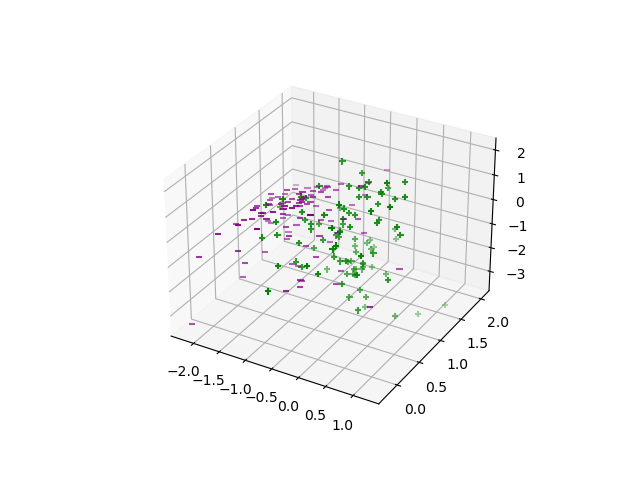

percent of positive samples: 49.2%


In [51]:
N = 1000
X, Y = gen_data(N, seed=111)
# X, Y = load_spam_dataset()
# X, Y = gen_data_case1()

assert(len(X[0]) == XDIM)
X, Y, Xval, Yval = split_data(X, Y, 0.25)
visualize_data(X, Y)
print("percent of positive samples: {}%".format(100 * len(Y[Y == 1]) / len(Y)))

# Train

In [52]:
def fit(evaluate, loss, params, X, Y, Xval, Yval, opt, opt_kwargs={"lr":1e-3}, batch_size=128, epochs=100, verbose=False, callback=None, calc_train_errors=False):
    
    train_dset = TensorDataset(X, Y)
    train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
    opt = opt(params, **opt_kwargs)

    train_losses = []
    val_losses = []
    train_errors = []
    val_errors = []
    
    total_time = time.time()
    for epoch in range(epochs):
        t1 = time.time()
        
        batch = 1
        train_losses.append([])
        train_errors.append([])
        for Xbatch, Ybatch in train_loader:
            opt.zero_grad()
            l = loss(Xbatch, Ybatch)
            l.backward()
            opt.step()
            train_losses[-1].append(l.item())
            if calc_train_errors:
                with torch.no_grad():
                    e = evaluate(Xbatch, Ybatch)
                    train_errors[-1].append(1-e)
                if verbose:
                    print("batch %03d / %03d | loss: %3.5f | err: %3.5f" % 
                          (batch, len(train_loader), np.mean(train_losses[-1]), np.mean(train_errors[-1])))
            else:
                if verbose:
                    print("batch %03d / %03d | loss: %3.5f" %
                          (batch, len(train_loader), np.mean(train_losses[-1])))
            batch += 1
            if callback is not None:
                callback()
                
        with torch.no_grad():
            val_losses.append(loss(Xval, Yval).item())
            val_errors.append(1-evaluate(Xval, Yval))
            
        t2 = time.time()
        if verbose:
            print("----- epoch %03d / %03d | time: %03d sec | loss: %3.5f | err: %3.5f" % (epoch + 1, epochs, t2-t1, val_losses[-1], val_errors[-1]))
    print("training time: {} seconds".format(time.time()-total_time)) 
    return train_errors, val_errors, train_losses, val_losses

def generate_delta_layer(funcs):
    g = funcs["g"]
    c = funcs["c"]
    
    x = cp.Variable(XDIM)
    w = cp.Parameter(XDIM, value = np.random.randn(XDIM))
    b = cp.Parameter(1, value = np.random.randn(1))
    r = cp.Parameter(XDIM, value = np.random.randn(XDIM))
    f_der = cp.Parameter(XDIM, value = np.random.randn(XDIM))

    target = x@f_der - g(x, w, b) - c(x, r)
    constraints = [x >= X_LOWER_BOUND,
                   x <= X_UPPER_BOUND]
    objective = cp.Maximize(target)
    problem = cp.Problem(objective, constraints)
    layer = CvxpyLayer(problem, parameters=[f_der, w, b, r], variables=[x])
    
    return layer

def generate_burden_layer(funcs):
    c = funcs["c"]
    score = funcs["score"]
    
    x = cp.Variable(XDIM)
    w = cp.Parameter(XDIM, value = np.random.randn(XDIM))
    b = cp.Parameter(1, value = np.random.randn(1))
    r = cp.Parameter(XDIM, value = np.random.randn(XDIM))

    target = c(x, r)
    constraints = [score(x, w, b) >= 0,
                   x >= X_LOWER_BOUND,
                   x <= X_UPPER_BOUND]
    
    objective = cp.Minimize(target)
    problem = cp.Problem(objective, constraints)
    layer = CvxpyLayer(problem, parameters=[w, b, r], variables=[x])
    
    return layer

def get_f_ders(XT, w, b):
    """
    tensor to tensor
    """
    return torch.stack([0.5*SLOPE_C*((SLOPE_C*score(xt, w, b) + 1)/torch.sqrt((SLOPE_C*score(xt, w, b) + 1)**2 + 1))*w for xt in XT])

def calc_burden(X, Y, w, b, burden_layer):
    """
    tensor to tensor
    """
    Xpos = X[Y==1]
    if len(Xpos) == 0:
        return 0
    X_min = burden_layer(w, b, Xpos)[0]
    return torch.mean((torch.sum(Xpos-X_min, dim=1))**2)

def calc_utility(X, Xopt, w, b):
    """
    tensor to tensor
    NOT GENERIC FOR f, g, c!!!
    """
    def gain_aux(S):
        return 0.5*(torch.sqrt((SLOPE_C*S + 1)**2 + 1) - torch.sqrt((SLOPE_C*S - 1)**2 + 1))
    
    def cost_aux(X1, X2):
        return torch.sum((X1-X2)**2, dim=1)
    
    S = score(Xopt, w, b)
    gain = gain_aux(S)
    cost = cost_aux(Xopt, X)
    return torch.mean(gain - cost)

In [53]:
LAMBDA = 0
ccp = CCP(funcs)
delta_layer = generate_delta_layer(funcs)
burden_layer = generate_burden_layer(funcs)

def loss(X, Y, w, b, lam, strategic=True):
    if strategic:
        XT = ccp.optimize_X(X, w, b)
        f_der = get_f_ders(XT, w, b)
        Xopt = delta_layer(f_der, w, b, X)[0] # Xopt should equal to XT but we do it again for the gradients
        output = score(Xopt, w, b)
        loss = torch.mean(torch.clamp(1 - output * Y, min=0))# + lam*calc_burden(X, Y, w, b, burden_layer) # - lam*calc_utility(X, Xopt, w, b)
    else:
        output = score(X, w, b)
        loss = torch.mean(torch.clamp(1 - output * Y, min=0))
    
    return loss

problem is DCP: True
problem is DPP: False


In [55]:
EPOCHS = 2
BATCH_SIZE = 32

# non-strategic classification
print("---------- training non-strategically ----------")
w_non_strategic = torch.zeros(XDIM, requires_grad=True)
b_non_strategic = torch.zeros(1, requires_grad=True)

train_errors1, val_errors1, train_losses1, val_losses1 = fit(lambda X, Y: evaluate_model(X, Y, w_non_strategic, b_non_strategic, ccp, strategic=False), 
                               lambda X, Y: loss(X, Y, w_non_strategic, b_non_strategic, LAMBDA, strategic=False),
                               [w_non_strategic, b_non_strategic], X, Y, Xval, Yval,
                               opt=torch.optim.Adam, opt_kwargs={"lr": 5*(1e-2)},
                               batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False)

w_non_strategic.requires_grad = False
b_non_strategic.requires_grad = False

# strategic classification
print("---------- training strategically ----------")
w_strategic = torch.zeros(XDIM, requires_grad=True)
b_strategic = torch.zeros(1, requires_grad=True)

train_errors, val_errors, train_losses, val_losses = fit(lambda X, Y: evaluate_model(X, Y, w_strategic, b_strategic, ccp, strategic=True), 
                               lambda X, Y: loss(X, Y, w_strategic, b_strategic, LAMBDA, strategic=True), [w_strategic, b_strategic], X, Y, Xval, Yval,
                               opt=torch.optim.Adam, opt_kwargs={"lr": 5*(1e-2)},
                               batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False)

w_strategic.requires_grad = False
b_strategic.requires_grad = False

---------- training non-strategically ----------
batch 001 / 024 | loss: 1.00000
batch 002 / 024 | loss: 1.00435
batch 003 / 024 | loss: 0.99150
batch 004 / 024 | loss: 0.97348
batch 005 / 024 | loss: 0.95467
batch 006 / 024 | loss: 0.94385
batch 007 / 024 | loss: 0.94527
batch 008 / 024 | loss: 0.93827
batch 009 / 024 | loss: 0.91930
batch 010 / 024 | loss: 0.91737
batch 011 / 024 | loss: 0.90176
batch 012 / 024 | loss: 0.91130
batch 013 / 024 | loss: 0.89332
batch 014 / 024 | loss: 0.88116
batch 015 / 024 | loss: 0.87227
batch 016 / 024 | loss: 0.86508
batch 017 / 024 | loss: 0.85138
batch 018 / 024 | loss: 0.84600
batch 019 / 024 | loss: 0.83161
batch 020 / 024 | loss: 0.82171
batch 021 / 024 | loss: 0.80672
batch 022 / 024 | loss: 0.79686
batch 023 / 024 | loss: 0.78893
batch 024 / 024 | loss: 0.77114
----- epoch 001 / 002 | time: 000 sec | loss: 0.61146 | err: 0.22800
batch 001 / 024 | loss: 0.41864
batch 002 / 024 | loss: 0.54096
batch 003 / 024 | loss: 0.53173
batch 004 / 024 | 

# Test results

In [56]:
Xval_opt = ccp.optimize_X(Xval, w_strategic, b_strategic)

FpXp = pred(Xval_opt, w_strategic, b_strategic)
FXp = pred(Xval_opt, w_non_strategic, b_non_strategic)
FpX = pred(Xval, w_strategic, b_strategic)
FX = pred(Xval, w_non_strategic, b_non_strategic)

social_burden = calc_burden(Xval, Yval, w_strategic, b_strategic, burden_layer)
utility = calc_utility(Xval, Xval_opt, w_strategic, b_strategic)

Average social burden: 0.12898929947430327
Average utility: -0.34776954145341804
y vs f(x):
[[42.   5.2]
 [12.8 40. ]]
accuracy: 82.0
y vs f(x'):
[[21.2 26. ]
 [ 0.8 52. ]]
accuracy: 73.2
y vs f'(x):
[[46.8  0.4]
 [34.8 18. ]]
accuracy: 64.8
y vs f'(x'):
[[39.6  7.6]
 [ 7.6 45.2]]
accuracy: 84.80000000000001


<IPython.core.display.Javascript object>


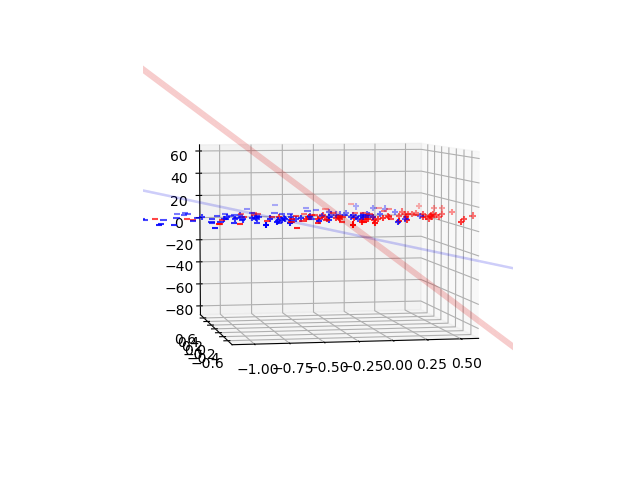

In [57]:

print("Average social burden: {}".format(social_burden))
print("Average utility: {}".format(utility))
print("y vs f(x):\n{}\naccuracy: {}".format(*conf_mat(Yval, FX)))
print("y vs f(x\'):\n{}\naccuracy: {}".format(*conf_mat(Yval, FXp)))
print("y vs f\'(x):\n{}\naccuracy: {}".format(*conf_mat(Yval, FpX)))
print("y vs f\'(x\'):\n{}\naccuracy: {}".format(*conf_mat(Yval, FpXp)))

visualize_strategic_data(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic)
